# Resultados EFAS5
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 25-09-2023*<br>

**Introducción:**<br>
En este _notebook_ se analizan los resultados del modelo LSTM que replica el caudal simulado en EFAS5 a partir de las series meteorológicas de EMO1 y los atributos estáticos derivados de los mapas estáticos de LISFLOOD y los parámetros calibrados del modelo LISFLOOD.

**Por hacer**:

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from neuralhydrology.utils.config import Config
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import geopandas as gpd
import glob
import yaml

from model_utils import *

## Configuración

In [2]:
with open("../config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# rutas de entrada y salida de datos
path_anuario = Path(cfg['rutas']['anuario_aforos'].get('repo', '../../data/anuario_aforos'))
path_camels = Path(cfg['rutas']['CAMELS'].get('repo', '../../data/CAMELS-ES/'))

### Estaciones

In [3]:
# cargar estaciones
estaciones = gpd.read_file(path_anuario / 'GIS/estaciones.shp')
estaciones.set_index('indroea', drop=True, inplace=True)
estaciones = estaciones.loc[estaciones.sel == 1]
# estaciones.index = estaciones.index.astype(int)

# definir qué estaciones se usan en el entrenamiento, validación y test
for period in ['train', 'validation', 'test']:
    sample = pd.read_csv(path_camels / f'basins_{period}.txt', header=None).squeeze().values.astype(str)
    estaciones[period] = 0
    estaciones.loc[sample, period] = 1

print(f'nº de estaciones:\t{estaciones.shape[0]}')
estaciones.head()

nº de estaciones:	269


,lugar,comentario,serv,suprest,suprcnc,hoja_id,alti,altimax,naa,naam,...,cod_saih,cuenca,caudal,inicio,fin,sel,geometry,train,validation,test
indroea,,,,,,,,,,,,,,,,,,,,,
1080,ANDOAIN,NaN,1,765,861,64,38.0,1544.0,65,65,...,A149,CANTABRICO,1,1991.0,2010.0,1,POINT (-2.02631 43.22834),0,1,0
1103,ALZOLA,INT 2003,0,456,531,63,44.0,1544.0,35,35,...,A800,CANTABRICO,1,1991.0,1998.0,1,POINT (-2.40099 43.22945),1,0,0
1105,EREÑOZU,NaN,1,215,266,64,28.0,1139.0,52,52,...,A900,CANTABRICO,1,1991.0,2020.0,1,POINT (-1.94154 43.24356),1,0,0
1106,ENDARLAZA,NaN,1,681,705,65,18.0,1418.0,50,50,...,A140,CANTABRICO,1,1991.0,2020.0,1,POINT (-1.72975 43.29500),0,0,1
1109,ECHABE,INT 2007,0,304,343,63,19.0,1423.0,34,34,...,A802,CANTABRICO,1,1991.0,2006.0,1,POINT (-2.23432 43.26692),1,0,0


### Simulación

In [32]:
import os

In [34]:
os.getcwd()

'C:\\GitHub\\TFM\\notebooks\\3_NeuralHydrology'

In [47]:
# definir experimento y simulación
experiment = 'EFAS5'
run = 'EFAS_test1_1709_081344'
run_dir = Path(f'{experiment}/runs/{run}')

In [48]:
# leer archivo de configuración
cfg = Config(run_dir / 'config.yml')
epochs = cfg.epochs
metric = cfg.metrics[0]
target = cfg.target_variables[0]

In [49]:
# extraer el rendimiento de cada época y muestra
metrics = {period: pd.DataFrame(columns=range(1, epochs + 1)) for period in ['train', 'validation', 'test']}
for period, df in tqdm(metrics.items()):
    for epoch in tqdm(df.columns):
        try:
            _, df[epoch] = get_results(run_dir, period, epoch=epoch)
            # # extraer series temporales
            # for id, dct in ts_period.items():
            #     for x in ['obs', 'sim']:
            #         ts = dct['1D']['xr'][f'{target}_{x}'].sel(time_step=0).to_pandas()
            #         ts.name = id
            #         timeseries[x] = pd.concat((timeseries[x], ts), axis=1)
        except:
            continue

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1257: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1264: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1272: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1273: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1257: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1264:

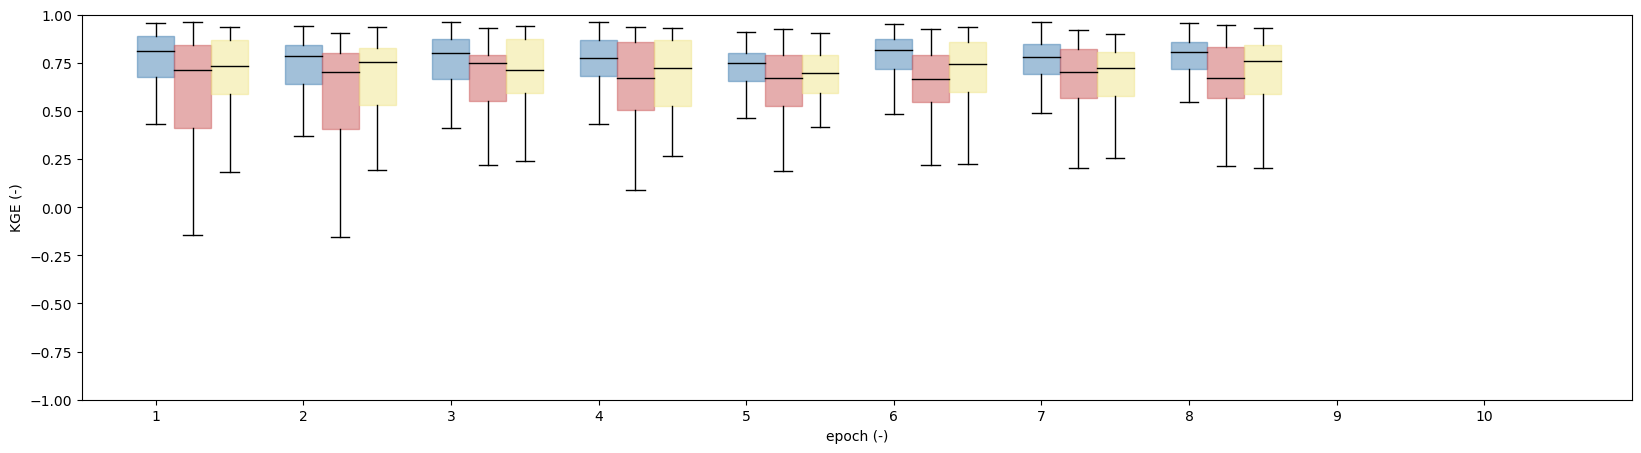

In [50]:
fig, ax = plt.subplots(figsize=(20, 5))

colors = ['steelblue', 'indianred', 'khaki']
for i, ((period, df), c) in enumerate(zip(metrics.items(), colors)):
    bp = ax.boxplot(df, positions=df.columns + i * .25, widths=0.25,
                    patch_artist=True,
                    boxprops={'color': c, 'alpha': .5},
                    # whiskerprops={},
                    showfliers=False,
                    medianprops={'color': 'k'})
    for box in bp['boxes']:
        box.set_facecolor(c)

ax.set_ylim(-1, 1);
xticks = np.linspace(1, epochs, num=epochs).astype(int)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set(xlabel='epoch (-)',
       ylabel=f'{metric} (-)');

***Figura 1**. Evolución del rendimento en las muestra de entrenamiento (azul), validación (rojo) y evaluación (amarillo) en cada época.*

In [51]:
# mejor época de cada muestra y el rendimiento de cada muestra en esa época
best_epoch = {}
for period, df in metrics.items():
    epoch = df.median().idxmax()
    best_epoch[period] = epoch
    print('epoch {0:>2}:\tKGEtrain = {1:.3f}   KGEval = {2:.3f}   KGEtest = {3:.3f}'.format(epoch,
                                                                                         metrics['train'][epoch].median(),
                                                                                         metrics['validation'][epoch].median(),
                                                                                         metrics['test'][epoch].median()))

epoch  6:	KGEtrain = 0.816   KGEval = 0.667   KGEtest = 0.744
epoch  3:	KGEtrain = 0.801   KGEval = 0.747   KGEtest = 0.712
epoch  8:	KGEtrain = 0.807   KGEval = 0.670   KGEtest = 0.760


In [13]:
# mejor época de cada muestra y el rendimiento de cada muestra en esa época
best_epoch = {}
for period, df in metrics.items():
    epoch = df.median().idxmax()
    best_epoch[period] = epoch
    print('epoch {0:>2}:\tKGEtrain = {1:.3f}   KGEval = {2:.3f}   KGEtest = {3:.3f}'.format(epoch,
                                                                                         metrics['train'][epoch].median(),
                                                                                         metrics['validation'][epoch].median(),
                                                                                         metrics['test'][epoch].median()))

epoch  1:	KGEtrain = 0.804   KGEval = 0.615   KGEtest = 0.708
epoch  1:	KGEtrain = 0.804   KGEval = 0.615   KGEtest = 0.708
epoch  1:	KGEtrain = 0.804   KGEval = 0.615   KGEtest = 0.708


In [16]:
# fig, ax = plt.subplots(figsize=(20, 5))

# colors = ['steelblue', 'indianred', 'k']
# for (period, df), c in zip(metrics.items(), colors):
#     aux = df.quantile([.25, .5, .75])
#     ax.plot(aux.loc[.5], c=c, lw=1, label=period)
#     ax.axvline(best_epoch[period], lw=1, ls='--', c=c)
#     ax.fill_between(aux.columns, aux.loc[.25], aux.loc[.75], color=c, alpha=.1)
# ax.set(xlabel='epoch',
#        xlim=(1 - .2, epochs + .2),
#        ylabel='KGE (-)',
#        ylim=(-1.02, 1.02));
# fig.legend(frameon=False, loc=8, ncol=3, bbox_to_anchor=[.3, -0.05, .4, .05]);

In [25]:
# extraer KGE de la mejor época
epoch = best_epoch['validation']
kge = pd.concat((metrics['train'][epoch], metrics['validation'][epoch], metrics['test'][epoch]), axis=0)
kge.name = 'KGE'
kge.index = kge.index.astype(str)

In [26]:
# añadir rendimiento en el shapefile de estaciones
estaciones = estaciones.loc[kge.index]
estaciones['KGE'] = kge

In [27]:
# export shapefile
estaciones.to_file(run_dir / f'estaciones_KGE.shp', index=True)